# Project Configs and Imports

In [161]:
import os
import warnings
import logging
from datetime import datetime
from pathlib import Path
import sys

warnings.filterwarnings('ignore')

# GPU configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Core data science libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, 
    Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Input, 
    concatenate, Bidirectional, GlobalMaxPooling1D, GRU
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, 
    TensorBoard, CSVLogger
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# Add these missing imports for metrics
from tensorflow.keras.metrics import Precision, Recall, AUC

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, log_loss,
    f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import pickle
from collections import Counter
import json
import joblib
from typing import Tuple, List, Dict, Any, Optional
import gc

# Additional useful libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Download NLTK data
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except Exception as e:
    print(f"Warning: Could not download NLTK data: {e}")

# Set random seeds for reproducibility
SEED = 67
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configure matplotlib
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Python version: {sys.version}")

TensorFlow version: 2.16.1
GPU available: []
Python version: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]


In [93]:
class Config:
    """Configuration class for LSTM model training"""
    
    # Model parameters
    MAX_WORDS = 50000  
    MAX_LENGTH = 250
    EMBEDDING_DIM = 100
    
    # Training parameters
    BATCH_SIZE = 64  
    EPOCHS = 50
    VALIDATION_SPLIT = 0.15  
    TEST_SIZE = 0.15 
    
    # Learning rate and optimization
    LEARNING_RATE = 0.001
    LEARNING_RATE_PATIENCE = 5
    LEARNING_RATE_FACTOR = 0.5
    
    # Regularization
    DROPOUT_RATE = 0.3
    RECURRENT_DROPOUT_RATE = 0.2
    L1_REGULARIZATION = 0.01
    L2_REGULARIZATION = 0.01
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 7
    EARLY_STOPPING_MIN_DELTA = 0.001
   
    DATA_PATH = 'siftmail/Datasets/master_dataset.csv'
    MODEL_SAVE_PATH = 'siftmail/Models/'
    TOKENIZER_SAVE_PATH = 'siftmail/Models/tokenizer.pickle'
    LOG_PATH = 'siftmail/Logs/'
    RESULTS_PATH = 'Results/'
   
    
    # Class labels mapping
    LABEL_MAPPING = {
        0: 'Other',
        1: 'Sent',  # Will be dropped
        2: 'Unclassified',  # Will be dropped
        3: 'Legal/Corporate',
        4: 'Personal',
        5: 'Business',
        6: 'Technical',
        7: 'Financial',
        8: 'Administrative',
        9: 'Marketing',
        10: 'Education'
    }
    
    @classmethod
    def create_directories(cls):
        """Create necessary directories if they don't exist"""
        directories = [cls.MODEL_SAVE_PATH, cls.LOG_PATH, cls.RESULTS_PATH]
        for directory in directories:
            Path(directory).mkdir(parents=True, exist_ok=True)

# Setup logging with better configuration
def setup_logging():
    """Setup comprehensive logging"""
    log_file = f"{Config.LOG_PATH}/lstm_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

# Initialize
Config.create_directories()
logger = setup_logging()

# LSTM Model for Natural Language Processing

In this notebook I present the process of how the LSTM Model was build including some preprocessing and feature engineering.

## Exploratory Data Analysis

In [137]:
def loadData(file_path: str) -> pd.DataFrame:
    """Load and validate the dataset with comprehensive error handling"""
    try:
        logger.info(f"Loading data from {file_path}")
        data = pd.read_csv(file_path, index_col=0)
        logger.info(f"Loaded dataset with shape: {data.shape}")
        
        # Validate required columns
        required_columns = ['Message-Body', 'label', 'Day_of_week', 'message_length']
        missing_columns = [col for col in required_columns if col not in data.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Check for null values
        null_counts = data[required_columns].isnull().sum()
        if null_counts.any():
            logger.warning(f"Null values found: {null_counts[null_counts > 0]}")
        
        # Basic data quality checks
        logger.info(f"Data types: {data[required_columns].dtypes}")
        logger.info(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        return data
        
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

# Load data
data = loadData(Config.DATA_PATH)
df = data.copy()

2025-08-04 14:41:03,684 - __main__ - INFO - Loading data from siftmail/Datasets/master_dataset.csv
2025-08-04 14:41:06,188 - __main__ - INFO - Loaded dataset with shape: (101288, 17)
2025-08-04 14:41:06,197 - __main__ - INFO - Data types: Message-Body       object
label             float64
Day_of_week        object
message_length      int64
dtype: object
2025-08-04 14:41:06,235 - __main__ - INFO - Memory usage: 384.84 MB


In [138]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the dataset with comprehensive cleaning"""
    logger.info("Starting data preprocessing")
    
    # Select relevant columns
    columns_to_keep = ['Message-Body', 'label', 'Day_of_week', 'message_length']
    df_processed = df[columns_to_keep].copy()
    
    # Remove null values
    initial_rows = len(df_processed)
    df_processed.dropna(axis=0, how='any', inplace=True)
    df_processed.reset_index(drop=True, inplace=True)
    
    logger.info(f"Removed {initial_rows - len(df_processed)} rows with null values")
    
    # Convert data types
    df_processed["label"] = df_processed["label"].astype('category')
    df_processed["Day_of_week"] = df_processed["Day_of_week"].astype('category')
    
    logger.info(f"Final dataset shape: {df_processed.shape}")
    return df_processed

df = preprocess_data(df)

2025-08-04 14:41:08,753 - __main__ - INFO - Starting data preprocessing
2025-08-04 14:41:08,766 - __main__ - INFO - Removed 0 rows with null values
2025-08-04 14:41:08,770 - __main__ - INFO - Final dataset shape: (101288, 4)


In [139]:
df.head()

,Message-Body,label,Day_of_week,message_length
0,loan servicing-jessica weeber 800-393-5626 jwe...,1.0,Mon,61
1,exit mccollough off 410,1.0,Mon,23
2,attached are two files that illustrate the fo...,1.0,Wed,181
3,financial (6)\n west desk (14)\nmid market ...,1.0,Tue,48
4,---------------------- forwarded by phillip k ...,1.0,Wed,511


As we can observe, we have 517401 rows and 4 columns counting the label. Let us convert both the day of the week and the label to categorical columns:

In [140]:
df["label"] = df["label"].astype('category')
df["Day_of_week"] = df["Day_of_week"].astype('category')

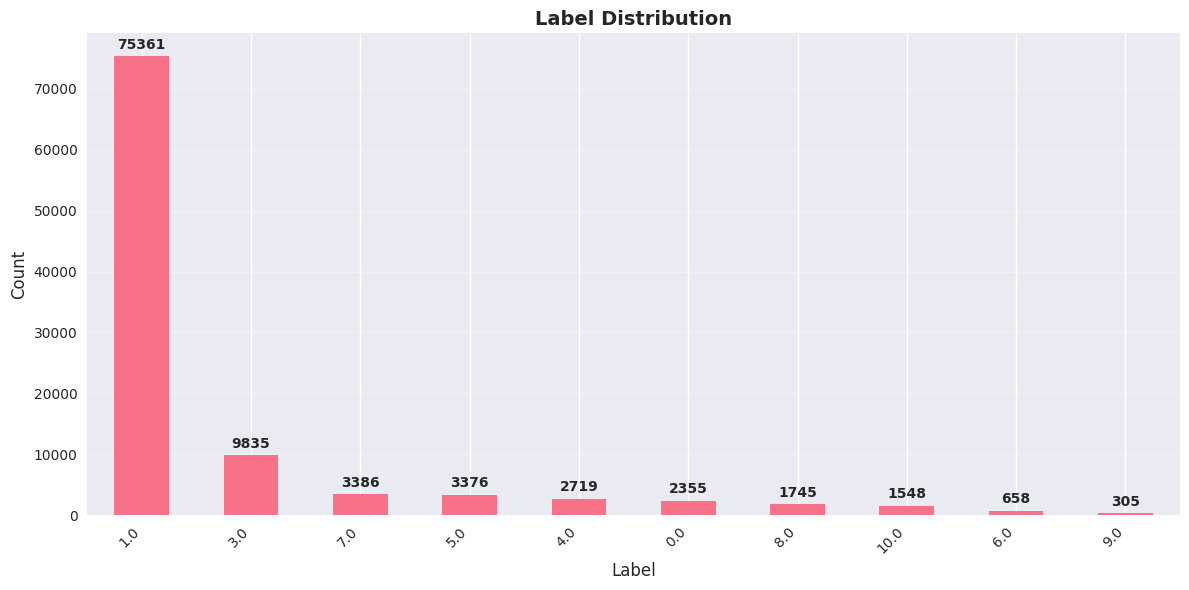

Label distribution:
label
1.0     75361
3.0      9835
7.0      3386
5.0      3376
4.0      2719
0.0      2355
8.0      1745
10.0     1548
6.0       658
9.0       305
Name: count, dtype: int64

Total samples: 101288
Number of classes: 10
Class imbalance ratio: 247.09
Message length statistics:
count    101288.000000
mean       1247.589171
std        1726.418974
min           1.000000
25%         214.000000
50%         635.000000
75%        1523.000000
max       10000.000000
Name: message_length, dtype: float64

Day of week distribution:
Day_of_week
Tue    21592
Wed    21298
Mon    19178
Thu    18983
Fri    16948
Sun     2238
Sat     1051
Name: count, dtype: int64

Word count statistics:
count    101288.000000
mean        183.571361
std         255.148948
min           1.000000
25%          33.000000
50%          94.000000
75%         222.000000
max        2494.000000
Name: Message-Body, dtype: float64


In [141]:
def analyze_label_distribution(df: pd.DataFrame, title: str = "Label Distribution") -> None:
    """Analyze and visualize label distribution"""
    label_counts = df['label'].value_counts().sort_values(ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    label_counts.plot(kind='bar')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Label', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(label_counts):
        plt.text(i, v + max(label_counts) * 0.01, str(v), 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Label distribution:")
    print(label_counts)
    print(f"\nTotal samples: {len(df)}")
    print(f"Number of classes: {len(label_counts)}")
    print(f"Class imbalance ratio: {label_counts.max() / label_counts.min():.2f}")

def analyze_text_statistics(df: pd.DataFrame) -> None:
    """Analyze text statistics"""
    # Message length statistics
    length_stats = df['message_length'].describe()
    print("Message length statistics:")
    print(length_stats)
    
    # Day of week distribution
    day_counts = df['Day_of_week'].value_counts()
    print("\nDay of week distribution:")
    print(day_counts)
    
    # Word count statistics
    word_counts = df['Message-Body'].str.split().str.len()
    word_stats = word_counts.describe()
    print("\nWord count statistics:")
    print(word_stats)

# Perform EDA
analyze_label_distribution(df)
analyze_text_statistics(df)

In [142]:
# We will drop several columns that are not useful for this model
df.drop(df.columns.difference(['Message-Body','label','Day_of_week', 'message_length']), axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

In [143]:
# Dropping rows with label 1 and 2
df = df.drop(df.query('label == 1').sample(frac=1).index)
df = df.drop(df.query('label == 2').sample(frac=1).index)

We can now visualize the new label distribution:

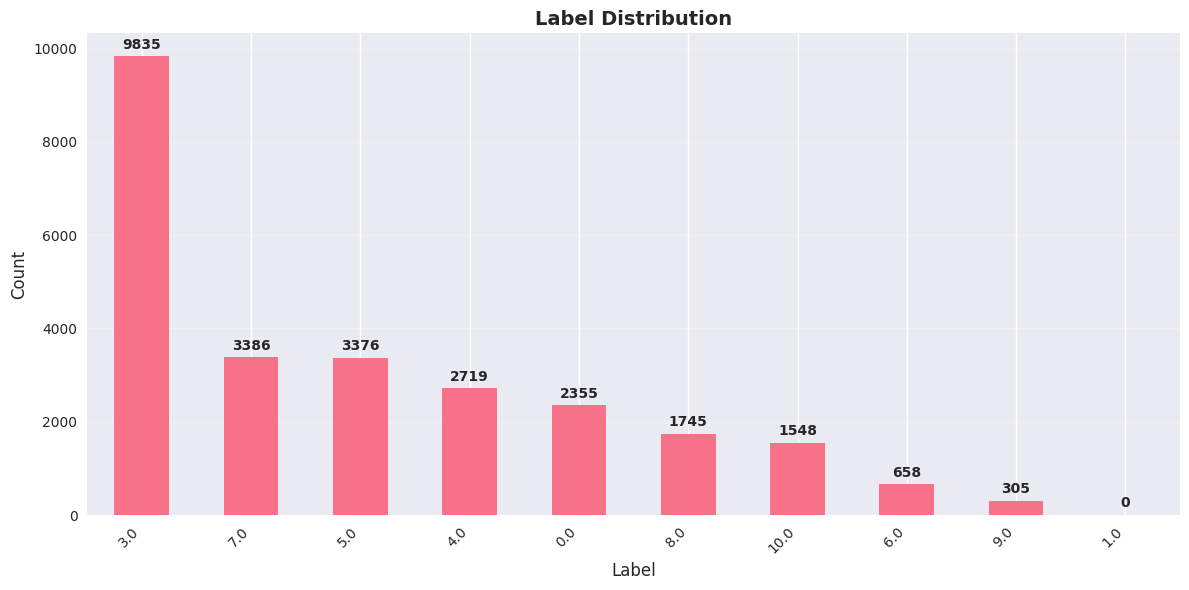

Label distribution:
label
3.0     9835
7.0     3386
5.0     3376
4.0     2719
0.0     2355
8.0     1745
10.0    1548
6.0      658
9.0      305
1.0        0
Name: count, dtype: int64

Total samples: 25927
Number of classes: 10
Class imbalance ratio: inf
Message length statistics:
count    25927.000000
mean      1556.843291
std       1970.140037
min          1.000000
25%        350.000000
50%        866.000000
75%       1882.500000
max      10000.000000
Name: message_length, dtype: float64

Day of week distribution:
Day_of_week
Tue    5243
Wed    5173
Thu    4977
Mon    4970
Fri    4841
Sun     482
Sat     241
Name: count, dtype: int64

Word count statistics:
count    25927.000000
mean       235.254792
std        295.634137
min          1.000000
25%         55.000000
50%        132.000000
75%        285.000000
max       2133.000000
Name: Message-Body, dtype: float64


In [144]:
analyze_label_distribution(df)
analyze_text_statistics(df)

There are a lot more data points with label = 3 which belongs to legal/corporate emails. Since this dataset belongs to ENRON corporation, it is to be expected that the majority of the emails belong to this class. Let us explore the contents of a few emails:

In [32]:
df = df.reset_index()

In [35]:
# Function to print the message and label for a datapoint
def print_message(index):
    example = df[df.index == index][['Message-Body', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])

In [36]:
print_message(10)

jennifer,
in regard to the costs for the gam conference, karen told me the $ 6,695.97 
figure was inclusive of all the items for the conference.  however, after 
speaking with shweta, i found out this is not the case.  the cds are not 
included in this figure.  

the cd cost will be $2,011.50 + the cost of postage/handling (which is 
currently being tabulated).

colleen

----- forwarded by colleen koenig/na/enron on 12/04/2000 10:56 am -----

	shweta sawhney
	12/04/2000 10:54 am
		 
		 to: colleen koenig/na/enron@enron
		 cc: 
		 subject: quotes for the cd's.

hi,

this is the original quote for this project and it did not include the 
postage. as soon as i have the details from the vendor, i'll forward those to 
you.
please call me if you have any questions.

thanks,
shweta.
----- forwarded by shweta sawhney/na/enron on 12/04/2000 10:52 am -----

	shweta sawhney
	10/30/2000 05:53 pm
		 
		 to: karina prizont/na/enron@enron
		 cc: karen hunter/enron_development@enron_development
		 sub

In [37]:
print_message(1000)

sally:

 please take a look at this letter.  we are comfortable with it, but you need 
to be as well before it's sent.  feel free to propose any changes.  otherwise 
you can let it fly.

brian

_______________________________________ 

dear energy operations:

as i have reflected upon the accomplishments of this group, i wanted to 
express my appreciation for all the hard work and dedication that you have 
demonstrated.  we have done great work and i want to recognize you for that.  

although we have done much, we have much yet to do.  therefore, as we go 
forward, i want to make sure that you have all the necessary tools to do the 
best possible job, and that any barriers that may impede your work are 
removed.

to help in this effort, i have asked a consulting organization -- s.j. bashen 
corporation -- to survey our organization; to "take its pulse" if you will; 
to help us understand what we do well and not so well; in essence, to assist 
us in acquiring the "necessary tools" and 

### Preprocessing: Cleaning Text 

Let us do some text cleaning since NLP models work better in clean text especially withouth unnecessary spaces.

In [185]:
def text_cleaning(text: str) -> str:
    """Advanced text cleaning with multiple preprocessing steps"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove special characters but keep important punctuation
    text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove numbers (optional - can be kept for financial/technical emails)
    # text = re.sub(r'\d+', '', text)
    
    return text

def clean_dataset_texts(df: pd.DataFrame) -> pd.DataFrame:
    """Clean all texts in the dataset"""
    logger.info("Starting text cleaning")
    
    df_cleaned = df.copy()
    df_cleaned['Message-Body'] = df_cleaned['Message-Body'].apply(text_cleaning)
    
    # Remove empty texts after cleaning
    initial_rows = len(df_cleaned)
    df_cleaned = df_cleaned[df_cleaned['Message-Body'].str.strip() != ''].copy()
    df_cleaned.reset_index(drop=True, inplace=True)
    
    logger.info(f"Removed {initial_rows - len(df_cleaned)} empty texts after cleaning")
    logger.info(f"Final dataset shape after cleaning: {df_cleaned.shape}")
    
    return df_cleaned

df = clean_dataset_texts(df)

2025-08-04 15:26:25,769 - __main__ - INFO - Starting text cleaning
2025-08-04 15:26:26,673 - __main__ - INFO - Removed 0 empty texts after cleaning
2025-08-04 15:26:26,674 - __main__ - INFO - Final dataset shape after cleaning: (25925, 4)


Know let us print the same two messages that we're previously showed to see the changes:

In [152]:
print_message(10)

jennifer in regard to the costs for the gam conference karen told me the $ 6 695.97 figure was inclusive of all the items for the conference. however after speaking with shweta i found out this is not the case. the cds are not included in this figure. the cd cost will be $2 011.50 + the cost of postage handling which is currently being tabulated . colleen ----- forwarded by colleen koenig na enron on 12 04 2000 10:56 am ----- shweta sawhney 12 04 2000 10:54 am to: colleen koenig na enron enron cc: subject: quotes for the cd's. hi this is the original quote for this project and it did not include the postage. as soon as i have the details from the vendor i'll forward those to you. please call me if you have any questions. thanks shweta. ----- forwarded by shweta sawhney na enron on 12 04 2000 10:52 am ----- shweta sawhney 10 30 2000 05:53 pm to: karina prizont na enron enron cc: karen hunter enron_development enron_development subject: quotes for the cd's. hi we have recieved the quotes

In [41]:
print_message(1000)

sally: please take a look at this letter. we are comfortable with it but you need to be as well before it's sent. feel free to propose any changes. otherwise you can let it fly. brian _______________________________________ dear energy operations: as i have reflected upon the accomplishments of this group i wanted to express my appreciation for all the hard work and dedication that you have demonstrated. we have done great work and i want to recognize you for that. although we have done much we have much yet to do. therefore as we go forward i want to make sure that you have all the necessary tools to do the best possible job and that any barriers that may impede your work are removed. to help in this effort i have asked a consulting organization -- s.j. bashen corporation -- to survey our organization to "take its pulse" if you will to help us understand what we do well and not so well in essence to assist us in acquiring the "necessary tools" and breaking down any "barriers." sjbc is

We can see that our text is cleaner and more concise. Let us do the embedding now.

## Building the Embedding

We will beging by fixing the number of words to take to generate the embedding. We will fix the input for prediction to 250 characters. We could do longer but for the purposese of this class we will stick with 250. The embedding will be taken arbitrarly to 100 dimensions:

In [153]:
# Maximum number of words based on highest frequency:
max_words = 1000000 
# Maximum number of words to be accepted when predicting. 
max_length = 250
# Setting the dimension of the embedding.
embedding_dim = 100

Let us tokenize the message:

In [156]:
def setup_tokenization(df: pd.DataFrame) -> Tuple[Tokenizer, np.ndarray]:
    """Setup tokenization with proper configuration"""
    logger.info("Setting up tokenization")
    
    # Create tokenizer
    tokenizer = Tokenizer(
        num_words=Config.MAX_WORDS, 
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
        lower=True,
        oov_token='<OOV>'
    )
    
    # Fit on texts
    tokenizer.fit_on_texts(df['Message-Body'].values)
    word_index = tokenizer.word_index
    
    logger.info(f"Vocabulary size: {len(word_index)}")
    logger.info(f"Most common words: {list(word_index.items())[:10]}")
    
    # Convert texts to sequences
    X = tokenizer.texts_to_sequences(df['Message-Body'].values)
    X = pad_sequences(X, maxlen=Config.MAX_LENGTH, padding='post', truncating='post')
    
    logger.info(f"Sequences shape: {X.shape}")
    
    return tokenizer, X

# Setup tokenization
tokenizer, X = setup_tokenization(df)

2025-08-04 14:51:32,687 - __main__ - INFO - Setting up tokenization
2025-08-04 14:51:34,136 - __main__ - INFO - Vocabulary size: 101909
2025-08-04 14:51:34,140 - __main__ - INFO - Most common words: [('<OOV>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('a', 6), ('in', 7), ('enron', 8), ('for', 9), ('is', 10)]
2025-08-04 14:51:35,124 - __main__ - INFO - Sequences shape: (25925, 250)


We will save the tokenizer with the pickle package since it will be a requirement when using the model for future predictions:

In [45]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Let us use the tokenizer to turn the text into sequences:

In [47]:
X = tokenizer.texts_to_sequences(df['Message-Body'].values)
X = pad_sequences(X, maxlen=max_length)

In [155]:
def encode_labels(df: pd.DataFrame) -> Tuple[np.ndarray, Dict]:
    """Encode labels with proper validation"""
    logger.info("Encoding labels")
    
    # Get unique labels
    unique_labels = sorted(df['label'].unique())
    logger.info(f"Unique labels: {unique_labels}")
    
    # Create label mapping
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    reverse_mapping = {idx: label for label, idx in label_mapping.items()}
    
    # Encode labels
    Y = pd.get_dummies(df['label']).values
    
    logger.info(f"Label encoding shape: {Y.shape}")
    logger.info(f"Label mapping: {label_mapping}")
    
    return Y, reverse_mapping

Y, label_mapping = encode_labels(df)

2025-08-04 14:49:34,064 - __main__ - INFO - Encoding labels
2025-08-04 14:49:34,066 - __main__ - INFO - Unique labels: [0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
2025-08-04 14:49:34,067 - __main__ - INFO - Label encoding shape: (25925, 10)
2025-08-04 14:49:34,067 - __main__ - INFO - Label mapping: {0.0: 0, 3.0: 1, 4.0: 2, 5.0: 3, 6.0: 4, 7.0: 5, 8.0: 6, 9.0: 7, 10.0: 8}


In [157]:
def create_feature_matrix(X: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    """Create comprehensive feature matrix"""
    logger.info("Creating feature matrix")
    
    # Convert sequences to DataFrame
    sequence_cols = [f'seq_{i}' for i in range(X.shape[1])]
    sequence_df = pd.DataFrame(X, columns=sequence_cols)
    
    # Add metadata features
    metadata_df = df[['Day_of_week', 'message_length']].copy()
    
    # One-hot encode day of week
    day_dummies = pd.get_dummies(metadata_df['Day_of_week'], prefix='Day')
    
    # Normalize message length
    scaler = MinMaxScaler()
    message_length_scaled = scaler.fit_transform(metadata_df[['message_length']])
    metadata_df['message_length_scaled'] = message_length_scaled
    
    # Combine all features
    feature_matrix = pd.concat([
        sequence_df,
        day_dummies,
        metadata_df[['message_length_scaled']]
    ], axis=1)
    
    logger.info(f"Feature matrix shape: {feature_matrix.shape}")
    logger.info(f"Feature columns: {list(feature_matrix.columns)}")
    
    return feature_matrix

# Create feature matrix
feature_matrix = create_feature_matrix(X, df)

2025-08-04 14:51:38,276 - __main__ - INFO - Creating feature matrix
2025-08-04 14:51:38,291 - __main__ - INFO - Feature matrix shape: (25925, 258)
2025-08-04 14:51:38,292 - __main__ - INFO - Feature columns: ['seq_0', 'seq_1', 'seq_2', 'seq_3', 'seq_4', 'seq_5', 'seq_6', 'seq_7', 'seq_8', 'seq_9', 'seq_10', 'seq_11', 'seq_12', 'seq_13', 'seq_14', 'seq_15', 'seq_16', 'seq_17', 'seq_18', 'seq_19', 'seq_20', 'seq_21', 'seq_22', 'seq_23', 'seq_24', 'seq_25', 'seq_26', 'seq_27', 'seq_28', 'seq_29', 'seq_30', 'seq_31', 'seq_32', 'seq_33', 'seq_34', 'seq_35', 'seq_36', 'seq_37', 'seq_38', 'seq_39', 'seq_40', 'seq_41', 'seq_42', 'seq_43', 'seq_44', 'seq_45', 'seq_46', 'seq_47', 'seq_48', 'seq_49', 'seq_50', 'seq_51', 'seq_52', 'seq_53', 'seq_54', 'seq_55', 'seq_56', 'seq_57', 'seq_58', 'seq_59', 'seq_60', 'seq_61', 'seq_62', 'seq_63', 'seq_64', 'seq_65', 'seq_66', 'seq_67', 'seq_68', 'seq_69', 'seq_70', 'seq_71', 'seq_72', 'seq_73', 'seq_74', 'seq_75', 'seq_76', 'seq_77', 'seq_78', 'seq_79', '

In [158]:
def split_data(X: pd.DataFrame, Y: np.ndarray, test_size: float = 0.15) -> Tuple:
    """Split data with proper stratification"""
    logger.info("Splitting data into train/test sets")
    
    # Ensure stratification is possible
    unique_labels = np.unique(np.argmax(Y, axis=1))
    logger.info(f"Number of unique classes: {len(unique_labels)}")
    
    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=test_size, 
        random_state=67, 
        stratify=np.argmax(Y, axis=1)
    )
    
    logger.info(f"Training set shape: {X_train.shape}")
    logger.info(f"Test set shape: {X_test.shape}")
    
    # Validate stratification
    train_labels = np.argmax(Y_train, axis=1)
    test_labels = np.argmax(Y_test, axis=1)
    
    logger.info("Class distribution in training set:")
    for i in range(Y_train.shape[1]):
        count = np.sum(train_labels == i)
        logger.info(f"  Class {i}: {count} ({count/len(train_labels)*100:.1f}%)")
    
    return X_train, X_test, Y_train, Y_test

# Split data
X_train, X_test, Y_train, Y_test = split_data(feature_matrix, Y, Config.TEST_SIZE)

2025-08-04 14:51:40,015 - __main__ - INFO - Splitting data into train/test sets
2025-08-04 14:51:40,017 - __main__ - INFO - Number of unique classes: 9
2025-08-04 14:51:40,037 - __main__ - INFO - Training set shape: (22036, 258)
2025-08-04 14:51:40,038 - __main__ - INFO - Test set shape: (3889, 258)
2025-08-04 14:51:40,038 - __main__ - INFO - Class distribution in training set:
2025-08-04 14:51:40,039 - __main__ - INFO -   Class 0: 2002 (9.1%)
2025-08-04 14:51:40,039 - __main__ - INFO -   Class 1: 0 (0.0%)
2025-08-04 14:51:40,040 - __main__ - INFO -   Class 2: 8359 (37.9%)
2025-08-04 14:51:40,041 - __main__ - INFO -   Class 3: 2310 (10.5%)
2025-08-04 14:51:40,041 - __main__ - INFO -   Class 4: 2870 (13.0%)
2025-08-04 14:51:40,041 - __main__ - INFO -   Class 5: 559 (2.5%)
2025-08-04 14:51:40,042 - __main__ - INFO -   Class 6: 2878 (13.1%)
2025-08-04 14:51:40,042 - __main__ - INFO -   Class 7: 1483 (6.7%)
2025-08-04 14:51:40,043 - __main__ - INFO -   Class 8: 259 (1.2%)
2025-08-04 14:51:

In [159]:
def separate_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple:
    """Separate embedding and metadata features"""
    logger.info("Separating embedding and metadata features")
    
    # Identify sequence columns
    sequence_cols = [col for col in X_train.columns if col.startswith('seq_')]
    metadata_cols = [col for col in X_train.columns if not col.startswith('seq_')]
    
    logger.info(f"Sequence columns: {len(sequence_cols)}")
    logger.info(f"Metadata columns: {len(metadata_cols)}")
    
    # Separate features
    X_train_emb = X_train[sequence_cols]
    X_train_meta = X_train[metadata_cols]
    X_test_emb = X_test[sequence_cols]
    X_test_meta = X_test[metadata_cols]
    
    return X_train_emb, X_train_meta, X_test_emb, X_test_meta

# Separate features
X_train_emb, X_train_meta, X_test_emb, X_test_meta = separate_features(X_train, X_test)

2025-08-04 14:51:42,192 - __main__ - INFO - Separating embedding and metadata features
2025-08-04 14:51:42,193 - __main__ - INFO - Sequence columns: 250
2025-08-04 14:51:42,194 - __main__ - INFO - Metadata columns: 8


In [162]:
def create_basic_lstm_model() -> tf.keras.Model:
    """Create a basic LSTM model"""
    logger.info("Creating basic LSTM model")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(Config.MAX_WORDS, Config.EMBEDDING_DIM),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(Config.EMBEDDING_DIM)),
        tf.keras.layers.Dense(Config.EMBEDDING_DIM, activation='relu'),
        tf.keras.layers.Dropout(Config.DROPOUT_RATE),
        tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')
    ])
    
    model.build(input_shape=(None, Config.MAX_LENGTH))
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        metrics=['accuracy', Precision(), Recall()]
    )
    
    logger.info("Basic LSTM model created")
    return model

# Create and train basic model
basic_model = create_basic_lstm_model()
basic_model.summary()

2025-08-04 14:52:31,625 - __main__ - INFO - Creating basic LSTM model
2025-08-04 14:52:31,672 - __main__ - INFO - Basic LSTM model created


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 250, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 200)            │       160,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,181,910 (19.77 MB)

 Trainable params: 5,181,910 (19.77 MB)

 Non-trainable params: 0 (0.00 B)

In [168]:
def create_advanced_lstm_model() -> tf.keras.Model:
    """Create an advanced LSTM model with better architecture"""
    logger.info("Creating advanced LSTM model")
    
    model = tf.keras.Sequential([
        # Embedding layer with input shape
        tf.keras.layers.Embedding(
            Config.MAX_WORDS, 
            Config.EMBEDDING_DIM,
            input_shape=(Config.MAX_LENGTH,)  # Add this line
        ),
        
        # Spatial dropout for regularization
        tf.keras.layers.SpatialDropout1D(0.2),
        
        # Bidirectional LSTM with dropout
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                128, 
                dropout=Config.DROPOUT_RATE, 
                recurrent_dropout=Config.RECURRENT_DROPOUT_RATE,
                return_sequences=True
            )
        ),
        
        # Second LSTM layer
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                64, 
                dropout=Config.DROPOUT_RATE, 
                recurrent_dropout=Config.RECURRENT_DROPOUT_RATE
            )
        ),
        
        # Dense layers with regularization
        tf.keras.layers.Dense(
            64, 
            activation='relu',
            kernel_regularizer=regularizers.l2(Config.L2_REGULARIZATION)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(Config.DROPOUT_RATE),
        
        # Output layer
        tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')
    ])
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        metrics=['accuracy']
    )
    
    logger.info("Advanced LSTM model created")
    return model

# Create advanced model
advanced_model = create_advanced_lstm_model()
advanced_model.summary()

2025-08-04 14:54:13,457 - __main__ - INFO - Creating advanced LSTM model
2025-08-04 14:54:13,508 - __main__ - INFO - Advanced LSTM model created


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 250, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 250, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 250, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,408,010 (20.63 MB)

 Trainable params: 5,407,882 (20.63 MB)

 Non-trainable params: 128 (512.00 B)

In [169]:
def create_callbacks(model_name: str) -> List:
    """Create comprehensive training callbacks"""
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=Config.EARLY_STOPPING_PATIENCE,
            min_delta=Config.EARLY_STOPPING_MIN_DELTA,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpointing
        ModelCheckpoint(
            filepath=f"{Config.MODEL_SAVE_PATH}/{model_name}_best.keras",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        
        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=Config.LEARNING_RATE_FACTOR,
            patience=Config.LEARNING_RATE_PATIENCE,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logging
        CSVLogger(
            filename=f"{Config.LOG_PATH}/{model_name}_training.csv",
            append=True
        )
    ]
    
    return callbacks

def train_model(model: tf.keras.Model, model_name: str) -> tf.keras.callbacks.History:
    """Train model with comprehensive monitoring"""
    logger.info(f"Training {model_name}")
    
    callbacks = create_callbacks(model_name)
    
    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(Y_train, axis=1)),
        y=np.argmax(Y_train, axis=1)
    )
    class_weight_dict = dict(zip(range(len(class_weights)), class_weights))
    
    logger.info(f"Class weights: {class_weight_dict}")
    
    # Train model
    history = model.fit(
        X_train_emb, Y_train,
        epochs=Config.EPOCHS,
        batch_size=Config.BATCH_SIZE,
        validation_split=Config.VALIDATION_SPLIT,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    logger.info(f"Training completed for {model_name}")
    return history

# Train advanced model
advanced_history = train_model(advanced_model, "advanced_lstm")

2025-08-04 14:55:00,966 - __main__ - INFO - Training advanced_lstm
2025-08-04 14:55:00,970 - __main__ - INFO - Class weights: {0: 1.222999222999223, 1: 0.2929111669391607, 2: 1.05993265993266, 3: 0.8531165311653116, 4: 4.380043728880938, 5: 0.8507451162072427, 6: 1.6510077170899828, 7: 9.453453453453454, 8: 1.8605200945626477}


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1733 - loss: 5.1895
Epoch 1: val_accuracy improved from -inf to 0.37235, saving model to siftmail/Models//advanced_lstm_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.1735 - loss: 5.1868 - val_accuracy: 0.3724 - val_loss: 2.3153 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3800 - loss: 3.2025
Epoch 2: val_accuracy improved from 0.37235 to 0.47489, saving model to siftmail/Models//advanced_lstm_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 72s 245ms/step - accuracy: 0.3802 - loss: 3.2016 - val_accuracy: 0.4749 - val_loss: 1.7290 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5070 - loss: 2.3795
Epoch 3: val_accuracy improved from 0.47489 to 0.51724, saving model to siftmail/Models//advanced_lstm_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 72s 245ms/step - accuracy: 0.5071 - loss: 2.3790 - val_accuracy: 0.5172 - val_lo

2025-08-04 15:10:35,489 - __main__ - INFO - Training completed for advanced_lstm


In [170]:
def create_multi_input_model() -> tf.keras.Model:
    """Create a multi-input model combining text and metadata"""
    logger.info("Creating multi-input model")
    
    # Text input branch
    text_input = Input(shape=(Config.MAX_LENGTH,))
    text_embedding = Embedding(Config.MAX_WORDS, Config.EMBEDDING_DIM)(text_input)
    text_dropout = SpatialDropout1D(0.2)(text_embedding)
    text_lstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(text_dropout)
    text_branch = Model(inputs=text_input, outputs=text_lstm)
    
    # Metadata input branch
    meta_input = Input(shape=(X_train_meta.shape[1],))
    meta_dense1 = Dense(32, activation='relu')(meta_input)
    meta_dropout = Dropout(0.3)(meta_dense1)
    meta_dense2 = Dense(16, activation='relu')(meta_dropout)
    meta_branch = Model(inputs=meta_input, outputs=meta_dense2)
    
    # Combine branches
    combined = concatenate([text_branch.output, meta_branch.output])
    
    # Final layers
    dense1 = Dense(64, activation='relu')(combined)
    dropout = Dropout(0.3)(dense1)
    output = Dense(Y_train.shape[1], activation='softmax')(dropout)
    
    # Create model
    model = Model(inputs=[text_branch.input, meta_branch.input], outputs=output)
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        metrics=['accuracy', Precision(), Recall()]
    )
    
    logger.info("Multi-input model created")
    return model

# Create multi-input model
multi_input_model = create_multi_input_model()
multi_input_model.summary()

2025-08-04 15:18:50,068 - __main__ - INFO - Creating multi-input model
2025-08-04 15:18:50,106 - __main__ - INFO - Multi-input model created


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_35        │ (None, 250, 100)  │  5,000,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 32)        │        288 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_7 │ (None, 250, 100)  │          0 │ embedding_35[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_27    │ (None, 128)       │     84,480 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 16)        │        528 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 144)       │          0 │ bidirectional_27… │
│ (Concatenate)       │                   │            │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 64)        │      9,280 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 10)        │        650 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,095,226 (19.44 MB)

 Trainable params: 5,095,226 (19.44 MB)

 Non-trainable params: 0 (0.00 B)

2025-08-04 15:20:45,515 - __main__ - INFO - Evaluating Advanced LSTM


Evaluating Advanced LSTM Model...
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step


2025-08-04 15:20:52,418 - __main__ - INFO - Advanced LSTM Results:
2025-08-04 15:20:52,419 - __main__ - INFO -   Accuracy: 0.5814
2025-08-04 15:20:52,419 - __main__ - INFO -   Precision: 0.5706
2025-08-04 15:20:52,420 - __main__ - INFO -   Recall: 0.5814
2025-08-04 15:20:52,420 - __main__ - INFO -   F1-Score: 0.5542


Plotting Training History...


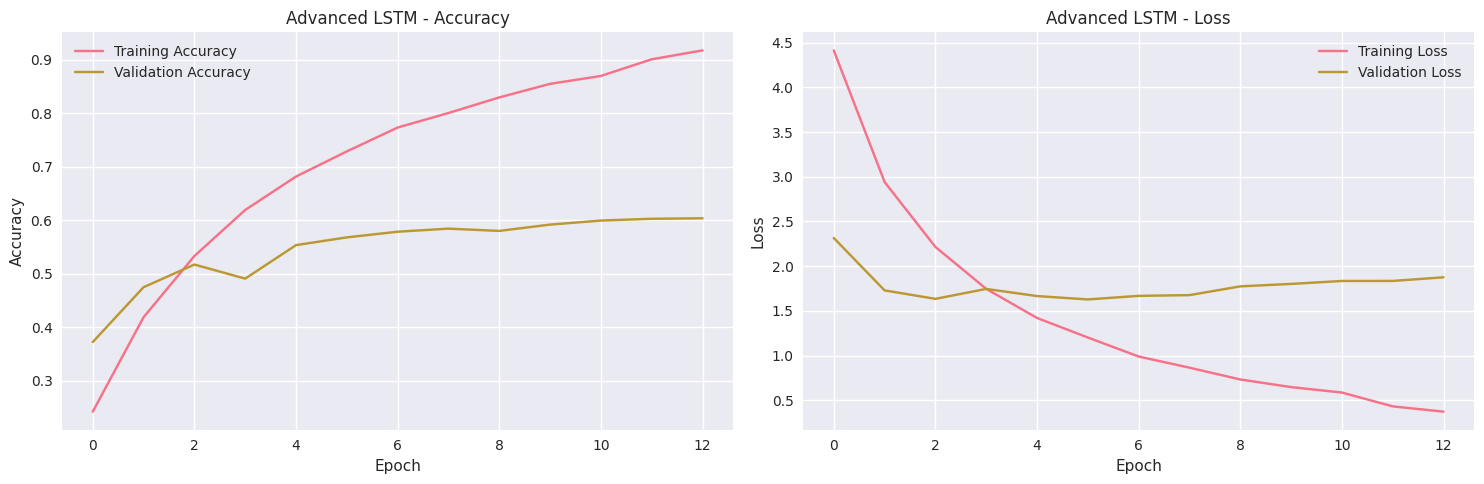

In [175]:
def evaluate_model(model: tf.keras.Model, X_test: np.ndarray, Y_test: np.ndarray, model_name: str) -> Dict:
    """Comprehensive model evaluation"""
    logger.info(f"Evaluating {model_name}")
    
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Classification report
    class_report = classification_report(y_true, y_pred, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Log results
    logger.info(f"{model_name} Results:")
    logger.info(f"  Accuracy: {accuracy:.4f}")
    logger.info(f"  Precision: {precision:.4f}")
    logger.info(f"  Recall: {recall:.4f}")
    logger.info(f"  F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Evaluate the advanced model
print("Evaluating Advanced LSTM Model...")
advanced_results = evaluate_model(advanced_model, X_test_emb, Y_test, "Advanced LSTM")

def plot_training_history(history: tf.keras.callbacks.History, model_name: str) -> None:
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
print("Plotting Training History...")
plot_training_history(advanced_history, "Advanced LSTM")


In [176]:
def save_model_and_tokenizer(model: tf.keras.Model, tokenizer: Tokenizer, model_name: str) -> None:
    """Save model and tokenizer with proper naming"""
    # Save model
    model_path = f"{Config.MODEL_SAVE_PATH}/{model_name}.keras"
    model.save(model_path)
    logger.info(f"Model saved to {model_path}")
    
    # Save tokenizer
    tokenizer_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_tokenizer.pickle"
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    logger.info(f"Tokenizer saved to {tokenizer_path}")
    
    # Save label mapping
    mapping_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_labels.json"
    with open(mapping_path, 'w') as f:
        json.dump(label_mapping, f)
    logger.info(f"Label mapping saved to {mapping_path}")

def load_model_and_tokenizer(model_name: str) -> Tuple[tf.keras.Model, Tokenizer, Dict]:
    """Load model, tokenizer, and label mapping"""
    # Load model
    model_path = f"{Config.MODEL_SAVE_PATH}/{model_name}.keras"
    model = tf.keras.models.load_model(model_path)
    
    # Load tokenizer
    tokenizer_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_tokenizer.pickle"
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    # Load label mapping
    mapping_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_labels.json"
    with open(mapping_path, 'r') as f:
        label_mapping = json.load(f)
    
    return model, tokenizer, label_mapping

In [186]:
def predict_text(text: str, model: tf.keras.Model, tokenizer: Tokenizer) -> Dict:

    cleaned_text = text_cleaning(text)

    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=Config.MAX_LENGTH, padding='post', truncating='post')

    prediction = model.predict(padded, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    try:
        original_label_value = label_mapping[predicted_class_idx]
    except KeyError:
        print(f"Warning: Class index {predicted_class_idx} not found in label_mapping")
        original_label_value = predicted_class_idx  # Fallback
    
    # Get the label name from Config
    predicted_label_name = Config.LABEL_MAPPING.get(int(original_label_value), f'Class_{int(original_label_value)}')
    
    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'predicted_class_idx': predicted_class_idx,
        'predicted_label_value': original_label_value,
        'predicted_label_name': predicted_label_name,
        'confidence': confidence,
        'probabilities': prediction[0].tolist()
    }

# Test the complete prediction with error handling
sample_texts = [
    "Technical support ticket #12345 has been resolved",
    "Please transfer the funds to account 12345",
    "Thank you for your interest in our MBA program",
    "The quarterly financial report shows positive growth",
    "I'm sorry, but I can't help with that. Please contact support.",
]

print("Complete prediction results:")
for text in sample_texts:
    result = predict_text(text, advanced_model, tokenizer)
    print(f"\nText: {result['text']}")
    print(f"Predicted: {result['predicted_label_name']} (confidence: {result['confidence']:.3f})")
    
    probs = [(i, p) for i, p in enumerate(result['probabilities'])]
    probs.sort(key=lambda x: x[1], reverse=True)
    print("Top 3 predictions:")
    for i, (class_idx, prob) in enumerate(probs[:3]):
        try:
            original_label = label_mapping[class_idx]
            label_name = Config.LABEL_MAPPING.get(int(original_label), f'Class_{int(original_label)}')
        except KeyError:
            label_name = f'Class_{class_idx}'
        print(f"  {i+1}. {label_name}: {prob:.3f}")

Complete prediction results:

Text: Technical support ticket #12345 has been resolved
Predicted: Personal (confidence: 0.669)
Top 3 predictions:
  1. Personal: 0.669
  2. Marketing: 0.104
  3. Business: 0.086

Text: Please transfer the funds to account 12345
Predicted: Personal (confidence: 0.388)
Top 3 predictions:
  1. Personal: 0.388
  2. Business: 0.218
  3. Class_9: 0.184

Text: Thank you for your interest in our MBA program
Predicted: Marketing (confidence: 0.627)
Top 3 predictions:
  1. Marketing: 0.627
  2. Class_9: 0.198
  3. Personal: 0.094

Text: The quarterly financial report shows positive growth
Predicted: Personal (confidence: 0.933)
Top 3 predictions:
  1. Personal: 0.933
  2. Business: 0.036
  3. Marketing: 0.009

Text: I'm sorry, but I can't help with that. Please contact support.
Predicted: Technical (confidence: 0.813)
Top 3 predictions:
  1. Technical: 0.813
  2. Personal: 0.108
  3. Business: 0.022
